### Fantasy Fumball: Using Machine Learning to Predict the Rank of Offensive Players in the NFL for Fantasy Football Drafting  

#### Introduction
Fantasy Sports is an industry estimated at over $7B per year (https://qz.com/1068534/how-the-7-billion-us-fantasy-football-industry-makes-its-money-in-2017/). It spans a host of sports and has spawned leagues and even a TV show (The League https://en.wikipedia.org/wiki/The_League) revolving around the players. My project specifically focused on fantasy football and selecting (aka drafting) the players that would be most likely to create a winning team. I set out to discover if it was possible to predict the rank of offensive players in the NFL for fantasy sports based on their statistics across the entire season.  

#### Fantasy Football Drafting and Assumptions  
Fantasy football is rife with stats for a data scientist. Most aspects of the game are quantified in discrete terms. I opted to only study offensive players that played positions that could be drafted onto my fantasy team. In this case, that meant evaluating the following positions: Quarterback (QB), Running back (RB), Wide Receiver (WR), Tight End (TE), and Kicker (K).  
As a note, due to time constraints, I opted to ignore defensive positions for this project. The data I pulled was for individual players and we typically draft an entire team defense. For future work, I would like to aggregate players of a team's defense and pull a full team score across the season to further improve my rank predictions.  

#### Data Collection  
My data is pulled from https://github.com/BurntSushi/nflgame, an API to read and retrieve NFL Game Center JSON Data. I will be using 2016 full season stats for my feature set. I also pulled the top 300 player rank, as ranked by ESPN, for my response vector. 

In [147]:
# read the data into a DataFrame named nfl16
import pandas as pd
path = '../GA_Class_Project/'
url = path + 'season2016_wy.csv'
nfl16 = pd.read_csv(url, index_col = 0)
nfl16.head()

,id,home,team,pos,defense_ast,defense_ffum,defense_int,defense_sk,defense_tkl,fumbles_lost,...,receiving_twopta,receiving_twoptm,receiving_yds,rushing_att,rushing_lng,rushing_lngtd,rushing_tds,rushing_twopta,rushing_twoptm,rushing_yds
name,,,,,,,,,,,,,,,,,,,,,
T.Siemian,00-0032156,no,DEN,QB,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,28.0,42.0,0.0,0.0,1.0,0.0,57.0
A.Janovich,00-0032956,no,DEN,FB,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,44.0,4.0,33.0,28.0,1.0,0.0,0.0,33.0
D.Booker,00-0032972,no,DEN,RB,NaN,NaN,NaN,NaN,NaN,3.0,...,0.0,0.0,265.0,174.0,152.0,21.0,4.0,0.0,0.0,612.0
C.Anderson,00-0029854,no,DEN,RB,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,128.0,110.0,106.0,13.0,4.0,0.0,0.0,437.0
V.Green,00-0028142,no,DEN,TE,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,237.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [148]:
# Determine total number of players in dataframe
nfl16.shape
# 1573 players in this list with 59 attributes

(1573, 59)

In [4]:
# Determine how many players would be eligible to be drafted based on open positions in a fantasy roster
# this includes QB, RB, WR, TE, K
nfl16.pos.value_counts()

WR     205
RB     146
DE     144
CB     129
TE     115
OLB     93
DT      90
DB      79
QB      71
LB      66
SS      52
ILB     44
FS      43
K       35
P       35
NT      25
OT      19
FB      18
MLB     16
C       16
OG      12
T        7
G        7
LS       6
SAF      3
Name: pos, dtype: int64

In [5]:
# create new DataFrames using only QB, WR, RB, TE, K
nfl16_QB = nfl16.loc[nfl16.pos == 'QB']
nfl16_WR = nfl16.loc[nfl16.pos == 'WR']
nfl16_RB = nfl16.loc[nfl16.pos == 'RB']
nfl16_TE = nfl16.loc[nfl16.pos == 'TE']
nfl16_K = nfl16.loc[nfl16.pos == 'K']

In [6]:
# concat all of those and call them offense
frames = [nfl16_QB, nfl16_WR, nfl16_RB, nfl16_TE, nfl16_K]
nfl16_off = pd.concat(frames)
nfl16_off.shape

(572, 59)

In [8]:
nfl16_off.head()

,id,home,team,pos,defense_ast,defense_ffum,defense_int,defense_sk,defense_tkl,fumbles_lost,...,receiving_twopta,receiving_twoptm,receiving_yds,rushing_att,rushing_lng,rushing_lngtd,rushing_tds,rushing_twopta,rushing_twoptm,rushing_yds
name,,,,,,,,,,,,,,,,,,,,,
T.Siemian,00-0032156,no,DEN,QB,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,28.0,42.0,0.0,0.0,1.0,0.0,57.0
C.Newton,00-0027939,no,CAR,QB,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,90.0,162.0,14.0,5.0,1.0,1.0,359.0
M.Ryan,00-0026143,no,ATL,QB,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,35.0,94.0,0.0,0.0,1.0,0.0,117.0
J.Winston,00-0031503,no,TB,QB,NaN,NaN,NaN,NaN,NaN,6.0,...,NaN,NaN,NaN,52.0,121.0,7.0,1.0,1.0,0.0,168.0
J.Flacco,00-0026158,no,BAL,QB,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,22.0,55.0,8.0,2.0,0.0,0.0,53.0


Players earn points based on their stats. The goal of your draft is to amass the highest scoring players on to your team. A breakdown point totals is below (https://fantasydata.com/resources/fantasy-scoring-system.aspx):  

Offensive Players  
•	Passing Yards: 1 point per 25 yards 
•	Passing Touchdowns: 4 points  
•	Passing Interceptions: -2 points  
•	Rushing Yards: 1 point per 10 yards  
•	Rushing Touchdowns: 6 points  
•	Receptions: 1 points (only if using PPR scoring)  
•	Receiving Yards: 1 point per 10 yards  
•	Receiving Touchdowns: 6 points  
•	2-Point Conversions: 2 points  
•	Fumbles Lost: -2 points  
•	Fumble Recovered for a Touchdown: 6 points  
Kicking  
•	Point After Touchdown (PAT) Made: 1 point  
•	Field Goal (FG) Made (0-49 yards): 3 points  
•	FG Made (50+ yards): 5 points  

The objective of my project is to come up with a way to rank players so I can increase my probability of picking great starters and finally win my league. 

In [9]:
nfl16_off.columns.values.tolist()

['id',
 'home',
 'team',
 'pos',
 'defense_ast',
 'defense_ffum',
 'defense_int',
 'defense_sk',
 'defense_tkl',
 'fumbles_lost',
 'fumbles_rcv',
 'fumbles_tot',
 'fumbles_trcv',
 'fumbles_yds',
 'kicking_fga',
 'kicking_fgm',
 'kicking_fgyds',
 'kicking_totpfg',
 'kicking_xpa',
 'kicking_xpb',
 'kicking_xpmade',
 'kicking_xpmissed',
 'kicking_xptot',
 'kickret_avg',
 'kickret_lng',
 'kickret_lngtd',
 'kickret_ret',
 'kickret_tds',
 'passing_att',
 'passing_cmp',
 'passing_ints',
 'passing_tds',
 'passing_twopta',
 'passing_twoptm',
 'passing_yds',
 'punting_avg',
 'punting_i20',
 'punting_lng',
 'punting_pts',
 'punting_yds',
 'puntret_avg',
 'puntret_lng',
 'puntret_lngtd',
 'puntret_ret',
 'puntret_tds',
 'receiving_lng',
 'receiving_lngtd',
 'receiving_rec',
 'receiving_tds',
 'receiving_twopta',
 'receiving_twoptm',
 'receiving_yds',
 'rushing_att',
 'rushing_lng',
 'rushing_lngtd',
 'rushing_tds',
 'rushing_twopta',
 'rushing_twoptm',
 'rushing_yds']

In [10]:
#create dataframe with only offensive stats
"""nfl16_off = nfl16_off[['id', 'home', 'team', 'pos', 'fumbles_lost', 'fumbles_rcv', 'fumbles_tot', 'fumbles_trcv',
 'fumbles_yds', 'kicking_fga', 'kicking_fgm', 'kicking_fgyds', 'kicking_totpfg', 'kicking_xpa', 'kicking_xpb',
 'kicking_xpmade', 'kicking_xpmissed', 'kicking_xptot', 'kickret_avg', 'kickret_lng', 'kickret_lngtd',
 'kickret_ret', 'kickret_tds', 'passing_att', 'passing_cmp', 'passing_ints', 'passing_tds', 'passing_twopta',
 'passing_twoptm', 'passing_yds', 'receiving_lng', 'receiving_lngtd', 'receiving_rec', 'receiving_tds',
 'receiving_twopta', 'receiving_twoptm', 'receiving_yds', 'rushing_att', 'rushing_lng', 'rushing_lngtd',
 'rushing_tds', 'rushing_twopta', 'rushing_twoptm', 'rushing_yds']]"""

"nfl16_off = nfl16_off[['id', 'home', 'team', 'pos', 'fumbles_lost', 'fumbles_rcv', 'fumbles_tot', 'fumbles_trcv',\n 'fumbles_yds', 'kicking_fga', 'kicking_fgm', 'kicking_fgyds', 'kicking_totpfg', 'kicking_xpa', 'kicking_xpb',\n 'kicking_xpmade', 'kicking_xpmissed', 'kicking_xptot', 'kickret_avg', 'kickret_lng', 'kickret_lngtd',\n 'kickret_ret', 'kickret_tds', 'passing_att', 'passing_cmp', 'passing_ints', 'passing_tds', 'passing_twopta',\n 'passing_twoptm', 'passing_yds', 'receiving_lng', 'receiving_lngtd', 'receiving_rec', 'receiving_tds',\n 'receiving_twopta', 'receiving_twoptm', 'receiving_yds', 'rushing_att', 'rushing_lng', 'rushing_lngtd',\n 'rushing_tds', 'rushing_twopta', 'rushing_twoptm', 'rushing_yds']]"

In [11]:
#nfl16_off.shape

### Points earned in fantasy, ignoring PPR   
y#### Offensive Players  
Passing Yards: 1 point per 25 yards  
Passing Touchdowns: 4 points  
Passing Interceptions: -2 points  
Rushing Yards: 1 point per 10 yards  
Rushing Touchdowns: 6 points  
Receptions: 1 points (only if using PPR scoring)  
Receiving Yards: 1 point per 10 yards  
Receiving Touchdowns: 6 points  
2-Point Conversions: 2 points  
Fumbles Lost: -2 points  
Fumble Recovered for a Touchdown: 6 points  

#### Kicking  
PAT Made: 1 point  
FG Made (0-49 yards): 3 points  
FG Made (50+ yards): 5 points
 

In [12]:
nfl16_off.head()

,id,home,team,pos,defense_ast,defense_ffum,defense_int,defense_sk,defense_tkl,fumbles_lost,...,receiving_twopta,receiving_twoptm,receiving_yds,rushing_att,rushing_lng,rushing_lngtd,rushing_tds,rushing_twopta,rushing_twoptm,rushing_yds
name,,,,,,,,,,,,,,,,,,,,,
T.Siemian,00-0032156,no,DEN,QB,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,28.0,42.0,0.0,0.0,1.0,0.0,57.0
C.Newton,00-0027939,no,CAR,QB,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,90.0,162.0,14.0,5.0,1.0,1.0,359.0
M.Ryan,00-0026143,no,ATL,QB,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,35.0,94.0,0.0,0.0,1.0,0.0,117.0
J.Winston,00-0031503,no,TB,QB,NaN,NaN,NaN,NaN,NaN,6.0,...,NaN,NaN,NaN,52.0,121.0,7.0,1.0,1.0,0.0,168.0
J.Flacco,00-0026158,no,BAL,QB,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,22.0,55.0,8.0,2.0,0.0,0.0,53.0


In [13]:
#map stats to points using list comprehensions
#is there a better way to do this?
fumbles_lost_pts = [x * -2 for x in nfl16_off.fumbles_lost]
passing_yds_pts = [x / 25 for x in nfl16_off.passing_yds]
passing_tds_pts = [x * 4 for x in nfl16_off.passing_tds]
passing_ints_pts = [x * -2 for x in nfl16_off.passing_ints]
rushing_yds_pts = [x / 10 for x in nfl16_off.rushing_yds]
rushing_tds_pts = [x * 6 for x in nfl16_off.rushing_tds]
receiving_yds_pts = [x / 10 for x in nfl16_off.receiving_yds]
receiving_tds_pts = [x * 6 for x in nfl16_off.receiving_tds]
passing_twoptm_pts = [x * 2 for x in nfl16_off.passing_twoptm]
receiving_twoptm_pts = [x * 2 for x in nfl16_off.receiving_twoptm]
rushing_twoptm_pts = [x * 2 for x in nfl16_off.rushing_twoptm]
kicking_xpmade_pts = [x * 1 for x in nfl16_off.kicking_xpmade]
# for now, counting all field goals as 3 points for ease of data parsing
kicking_fgm_pts = [x * 3 for x in nfl16_off.kicking_fgm]

In [14]:
# fgyds doesn't work across entire season
# maybe find a loop to calculate this separately?
# I think rushing/receiving yards still okay bc we're not counting any bonuses per game

#kicking_fgyds_pts = [x * 3 if x < 49 else x * 5 in nfl16_off.kicking_fgyds]

In [37]:
# create dataframe for list of pts, give it the same index as before
nflpts = pd.DataFrame(list(zip(fumbles_lost_pts, passing_yds_pts, passing_tds_pts, passing_ints_pts, rushing_yds_pts, rushing_tds_pts, receiving_yds_pts, receiving_tds_pts, passing_twoptm_pts, receiving_twoptm_pts, rushing_twoptm_pts, kicking_xpmade_pts, kicking_fgm_pts)),
                      index = nfl16_off.index,
                      columns=['fumbles_lost_pts', 'passing_yds_pts', 'passing_tds_pts', 'passing_ints_pts', 'rushing_yds_pts', 'rushing_tds_pts', 'receiving_yds_pts', 'receiving_tds_pts', 'passing_twoptm_pts', 'receiving_twoptm_pts', 'rushing_twoptm_pts', 'kicking_xpmade_pts', 'kicking_fgm_pts'])

type(nflpts)

pandas.core.frame.DataFrame

In [38]:
nflpts.head()

,fumbles_lost_pts,passing_yds_pts,passing_tds_pts,passing_ints_pts,rushing_yds_pts,rushing_tds_pts,receiving_yds_pts,receiving_tds_pts,passing_twoptm_pts,receiving_twoptm_pts,rushing_twoptm_pts,kicking_xpmade_pts,kicking_fgm_pts
name,,,,,,,,,,,,,
T.Siemian,-4.0,136.08,72.0,-20.0,5.7,0.0,NaN,NaN,2.0,NaN,0.0,NaN,NaN
C.Newton,-4.0,140.36,76.0,-28.0,35.9,30.0,NaN,NaN,2.0,NaN,2.0,NaN,NaN
M.Ryan,-4.0,197.76,152.0,-14.0,11.7,0.0,NaN,NaN,2.0,NaN,0.0,NaN,NaN
J.Winston,-12.0,163.60,112.0,-36.0,16.8,6.0,NaN,NaN,6.0,NaN,0.0,NaN,NaN
J.Flacco,-6.0,172.68,80.0,-30.0,5.3,12.0,NaN,NaN,8.0,NaN,0.0,NaN,NaN


In [15]:
nfl16_off.index

Index([u'T.Siemian', u'C.Newton', u'M.Ryan', u'J.Winston', u'J.Flacco',
       u'T.Taylor', u'B.Osweiler', u'J.Cutler', u'B.Bortles', u'A.Rodgers',
       ...
       u'C.Catanzaro', u'S.Gostkowski', u'D.Hopkins', u'C.Boswell',
       u'P.Dawson', u'G.Zuerlein', u'C.Parkey', u'J.Brown', u'R.Gould',
       u'K.Forbath'],
      dtype='object', name=u'name', length=572)

In [16]:
nfl16_off.describe()

,defense_ast,defense_ffum,defense_int,defense_sk,defense_tkl,fumbles_lost,fumbles_rcv,fumbles_tot,fumbles_trcv,fumbles_yds,...,receiving_twopta,receiving_twoptm,receiving_yds,rushing_att,rushing_lng,rushing_lngtd,rushing_tds,rushing_twopta,rushing_twoptm,rushing_yds
count,4.0,4.00,4.0,4.0,4.0,252.000000,252.000000,252.000000,252.000000,252.000000,...,447.000000,447.000000,447.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,0.0,0.25,0.0,0.0,1.0,1.055556,0.857143,2.293651,0.920635,-0.698413,...,0.149888,0.067114,289.908277,44.252525,71.245791,12.329966,1.454545,0.077441,0.047138,185.841751
std,0.0,0.50,0.0,0.0,0.0,1.189634,1.151575,2.388777,1.140372,5.555615,...,0.475775,0.284055,323.227062,68.778534,89.390713,28.053139,2.780018,0.324760,0.242036,300.756982
min,0.0,0.00,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-29.000000,...,0.000000,0.000000,-16.000000,1.000000,-8.000000,0.000000,0.000000,0.000000,0.000000,-12.000000
25%,0.0,0.00,0.0,0.0,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,46.000000,2.000000,7.000000,0.000000,0.000000,0.000000,0.000000,7.000000
50%,0.0,0.00,0.0,0.0,1.0,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,154.000000,11.000000,31.000000,0.000000,0.000000,0.000000,0.000000,44.000000
75%,0.0,0.25,0.0,0.0,1.0,1.000000,1.000000,3.000000,1.000000,0.000000,...,0.000000,0.000000,428.500000,57.000000,103.000000,9.000000,2.000000,0.000000,0.000000,209.000000
max,0.0,1.00,0.0,0.0,1.0,6.000000,7.000000,14.000000,7.000000,42.000000,...,3.000000,2.000000,1448.000000,322.000000,405.000000,174.000000,18.000000,3.000000,2.000000,1631.000000


In [17]:
url = path + 'rank2016_wy.csv'
nflrank = pd.read_csv(url, index_col = 'name')
nflrank.head()

,rank,pos
name,,
A.Brown,1,WR
O.Beckham,2,WR
A.Peterson,3,RB
J.Jones,4,WR
T.Gurley,5,RB


In [18]:
nflrank = nflrank.drop('pos', 1)
nflrank.head()

,rank
name,
A.Brown,1
O.Beckham,2
A.Peterson,3
J.Jones,4
T.Gurley,5


In [47]:
print nfl16_off.shape
print nflrank.shape
print nflpts.shape

(572, 59)
(300, 1)
(572, 13)


In [48]:
# nfl = pd.concat([nfl16_off, nflpts], axis = 1)

In [59]:
# create dataframe with rank and pts
nfl = nflpts.join(nflrank)
nfl.head()

,fumbles_lost_pts,passing_yds_pts,passing_tds_pts,passing_ints_pts,rushing_yds_pts,rushing_tds_pts,receiving_yds_pts,receiving_tds_pts,passing_twoptm_pts,receiving_twoptm_pts,rushing_twoptm_pts,kicking_xpmade_pts,kicking_fgm_pts,rank
name,,,,,,,,,,,,,,
A.Abdullah,NaN,NaN,NaN,NaN,10.1,0.0,5.7,6.0,NaN,0.0,0.0,NaN,NaN,75.0
A.Benn,NaN,NaN,NaN,NaN,NaN,NaN,11.6,6.0,NaN,0.0,NaN,NaN,NaN,NaN
A.Blue,-2.0,NaN,NaN,NaN,41.6,6.0,4.0,0.0,NaN,0.0,0.0,NaN,NaN,277.0
A.Boldin,NaN,NaN,NaN,NaN,NaN,NaN,58.4,48.0,NaN,0.0,NaN,NaN,NaN,183.0
A.Brown,NaN,NaN,NaN,NaN,0.9,0.0,128.4,72.0,NaN,0.0,0.0,NaN,NaN,1.0


In [62]:
nfl.describe()

,fumbles_lost_pts,passing_yds_pts,passing_tds_pts,passing_ints_pts,rushing_yds_pts,rushing_tds_pts,receiving_yds_pts,receiving_tds_pts,passing_twoptm_pts,receiving_twoptm_pts,rushing_twoptm_pts,kicking_xpmade_pts,kicking_fgm_pts,rank
count,259.000000,90.000000,90.000000,90.000000,303.000000,303.000000,456.000000,456.000000,90.000000,456.000000,303.000000,35.000000,35.000000,293.000000
mean,-2.123552,58.120000,34.888889,-9.222222,18.957426,8.990099,29.542982,10.657895,0.800000,0.135965,0.092409,31.885714,72.771429,140.515358
std,2.365815,70.153902,45.603185,11.478145,30.470597,17.276000,32.678513,14.351523,1.768641,0.569500,0.479419,11.485980,23.264573,87.525597
min,-12.000000,0.000000,0.000000,-42.000000,-1.200000,0.000000,-1.600000,0.000000,0.000000,0.000000,0.000000,9.000000,24.000000,1.000000
25%,-2.000000,0.820000,0.000000,-15.500000,0.700000,0.000000,4.750000,0.000000,0.000000,0.000000,0.000000,23.500000,57.000000,63.000000
50%,-2.000000,17.260000,8.000000,-4.000000,5.000000,0.000000,15.750000,6.000000,0.000000,0.000000,0.000000,32.000000,78.000000,132.000000
75%,-0.000000,136.800000,71.000000,-0.000000,23.300000,12.000000,44.325000,18.000000,1.500000,0.000000,0.000000,40.500000,88.500000,217.000000
max,-0.000000,208.320000,160.000000,-0.000000,163.100000,108.000000,144.800000,84.000000,10.000000,4.000000,4.000000,56.000000,114.000000,296.000000


In [68]:
nfl.isnull().sum()

fumbles_lost_pts        323
passing_yds_pts         492
passing_tds_pts         492
passing_ints_pts        492
rushing_yds_pts         279
rushing_tds_pts         279
receiving_yds_pts       126
receiving_tds_pts       126
passing_twoptm_pts      492
receiving_twoptm_pts    126
rushing_twoptm_pts      279
kicking_xpmade_pts      547
kicking_fgm_pts         547
rank                    289
dtype: int64

In [80]:
nfl.columns.tolist()

['fumbles_lost_pts',
 'passing_yds_pts',
 'passing_tds_pts',
 'passing_ints_pts',
 'rushing_yds_pts',
 'rushing_tds_pts',
 'receiving_yds_pts',
 'receiving_tds_pts',
 'passing_twoptm_pts',
 'receiving_twoptm_pts',
 'rushing_twoptm_pts',
 'kicking_xpmade_pts',
 'kicking_fgm_pts',
 'rank']

In [91]:
#dropna can remove nulls but might be too much
#using means to fill in dataframe
# tried to write a forloop for this but it wouldn't do it

nfl.fumbles_lost_pts.fillna(nfl.fumbles_lost_pts.mean(),inplace = True)
nfl.passing_yds_pts.fillna(nfl.passing_yds_pts.mean(),inplace = True)
nfl.passing_tds_pts.fillna(nfl.passing_tds_pts.mean(),inplace = True)
nfl.passing_ints_pts.fillna(nfl.passing_ints_pts.mean(),inplace = True)
nfl.rushing_yds_pts.fillna(nfl.rushing_yds_pts.mean(),inplace = True)
nfl.rushing_tds_pts.fillna(nfl.rushing_tds_pts.mean(),inplace = True)
nfl.receiving_yds_pts.fillna(nfl.receiving_yds_pts.mean(),inplace = True)
nfl.receiving_tds_pts.fillna(nfl.receiving_tds_pts.mean(),inplace = True)
nfl.passing_twoptm_pts.fillna(nfl.passing_twoptm_pts.mean(),inplace = True)
nfl.receiving_twoptm_pts.fillna(nfl.receiving_twoptm_pts.mean(),inplace = True)
nfl.rushing_twoptm_pts.fillna(nfl.rushing_twoptm_pts.mean(),inplace = True)
nfl.kicking_xpmade_pts.fillna(nfl.kicking_xpmade_pts.mean(),inplace = True)
nfl.kicking_fgm_pts.fillna(nfl.kicking_fgm_pts.mean(),inplace = True)
nfl.head()

,fumbles_lost_pts,passing_yds_pts,passing_tds_pts,passing_ints_pts,rushing_yds_pts,rushing_tds_pts,receiving_yds_pts,receiving_tds_pts,passing_twoptm_pts,receiving_twoptm_pts,rushing_twoptm_pts,kicking_xpmade_pts,kicking_fgm_pts,rank
name,,,,,,,,,,,,,,
A.Abdullah,-2.123552,58.12,34.888889,-9.222222,10.100000,0.000000,5.7,6.0,0.8,0.0,0.000000,31.885714,72.771429,75.0
A.Benn,-2.123552,58.12,34.888889,-9.222222,18.957426,8.990099,11.6,6.0,0.8,0.0,0.092409,31.885714,72.771429,NaN
A.Blue,-2.000000,58.12,34.888889,-9.222222,41.600000,6.000000,4.0,0.0,0.8,0.0,0.000000,31.885714,72.771429,277.0
A.Boldin,-2.123552,58.12,34.888889,-9.222222,18.957426,8.990099,58.4,48.0,0.8,0.0,0.092409,31.885714,72.771429,183.0
A.Brown,-2.123552,58.12,34.888889,-9.222222,0.900000,0.000000,128.4,72.0,0.8,0.0,0.000000,31.885714,72.771429,1.0


In [ ]:
# okay let's make some graphs?


In [ ]:


#so maybe the easy prediction is total points scored compared to rank?
#I was thinking it would be better to look at do receivers rank better or qbs or otherwise?
#so maybe i should sum up total points but also find a way to turn position into a numbered variable?






  
I will be using random forest and logistic regression as my estimators to predict fantasy ranks.  

In [95]:
# trying random forest
nfl.dropna(inplace = True)
nfl.shape

(293, 14)

In [99]:
#define X and y
feature_cols = nfl.columns.drop('rank')
feature_cols
X = nfl[feature_cols]
y = nfl['rank']

In [103]:
# predicting rank with a Random Forest
import numpy as np
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor()
rfreg

# list of values to try for n_estimators
estimator_range = range(10, 310, 10)
# 10 estimators, up to 300, in steps of 10

# list to store the average RMSE for each value of n_estimators
RMSE_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
from sklearn.model_selection import cross_val_score
for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

print RMSE_scores

[86.985993959398655, 84.452656790881136, 83.856469397161931, 83.627020893042669, 83.927734146663596, 83.83281610850031, 83.917942608517052, 83.92673386473902, 83.670938260556554, 83.621203699851065, 83.42323357564571, 83.449267928140316, 83.550642446778383, 83.371288608038483, 83.318774882426823, 83.116231392883407, 83.118096727649515, 82.836403523574717, 82.681373470424504, 82.677237398549877, 82.700513487004258, 82.833220915372266, 82.846000200701496, 82.788837968189043, 82.757991251725997, 82.794699200086924, 82.744497716083231, 82.754503529206275, 82.713488853880719, 82.766658416765821]


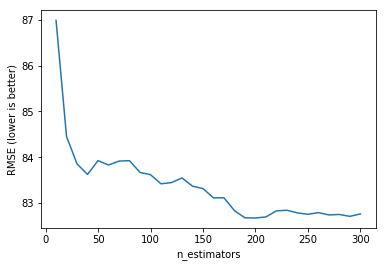

In [105]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

# plot n_estimators (x-axis) versus RMSE (y-axis)
plt.plot(estimator_range, RMSE_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE (lower is better)')
# about 200 estimators seems good

In [106]:
# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)

# list to store the average RMSE for each value of max_features
RMSE_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=60, max_features=feature, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

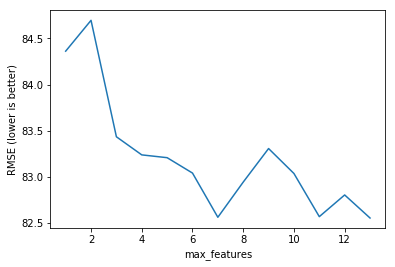

In [107]:
# plot max_features (x-axis) versus RMSE (y-axis)
plt.plot(feature_range, RMSE_scores)
plt.xlabel('max_features')
plt.ylabel('RMSE (lower is better)')
# 7 or 11 features is good

In [108]:
# show the best RMSE and the corresponding max_features
sorted(zip(RMSE_scores, feature_range))[0]
# but using all 13 is best

(82.554394085442411, 13)

In [109]:
# max_features=13 is best and n_estimators=200 
rfreg = RandomForestRegressor(n_estimators=200, max_features=13, oob_score=True, random_state=1)
rfreg.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=13, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=1, oob_score=True, random_state=1,
           verbose=0, warm_start=False)

In [110]:
# compute feature importances
pd.DataFrame({'feature':feature_cols, 'importance':rfreg.feature_importances_}).sort_values('importance', ascending=False)
# looks like receiving yds and rushing yds are most important
# this makes sense since you have more of those spots available on your team

,feature,importance
6,receiving_yds_pts,0.423221
4,rushing_yds_pts,0.253113
7,receiving_tds_pts,0.098653
0,fumbles_lost_pts,0.050991
5,rushing_tds_pts,0.046552
2,passing_tds_pts,0.028909
12,kicking_fgm_pts,0.022524
11,kicking_xpmade_pts,0.020202
1,passing_yds_pts,0.015087
9,receiving_twoptm_pts,0.012336


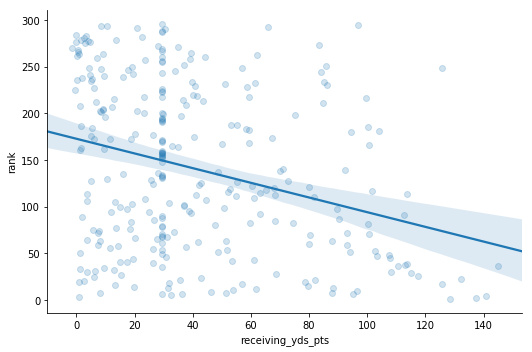

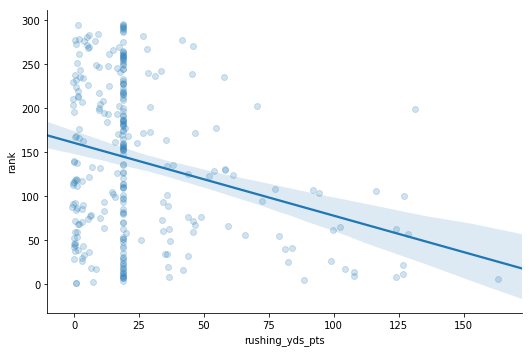

In [132]:
# starting with scatter plots and linreg lines for receiving and rushing yds
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

print sns.lmplot(x='receiving_yds_pts', y='rank', data=nfl, aspect=1.5, scatter_kws={'alpha':0.2})
print sns.lmplot(x='rushing_yds_pts', y='rank', data=nfl, aspect=1.5, scatter_kws={'alpha':0.2})
# well linear regression is not going to work

In [114]:
# so lets look at logreg on receiving yds and rushing yds
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
from sklearn.model_selection import train_test_split

In [135]:
feature_cols_imp = ['receiving_yds_pts', 'rushing_yds_pts']
Ximp = nfl[feature_cols_imp]
yimp = nfl['rank']

Ximp_tr, Ximp_te, yimp_tr, yimp_te = train_test_split(Ximp, yimp, random_state = 1)

logreg.fit(Ximp_tr, yimp_tr)
nfl_pred_class = logreg.predict(Ximp_tr)
print logreg.coef_.max()
# but who is it???

0.0519851464004


In [142]:
# do logreg rmse
from sklearn.metrics import mean_squared_error
logregMSE = mean_squared_error(yimp_tr, nfl_pred_class)

logregRMSE = np.sqrt(logregMSE)
print logregRMSE

# then compare to null rmse
# create a NumPy array with the same shape as y_test
yimp_null = np.zeros_like(yimp_te, dtype=float)

# fill the array with the mean value of y_test
yimp_null.fill(yimp_te.mean())

nullRMSE = np.sqrt(mean_squared_error(yimp_te, yimp_null))
print nullRMSE
# pretty sure my error is much worse than null which means something is terribly wrong.

130.648645202
80.8009349475


#### Future work
- See if I can predict improvement in players across years.  
- Split apart field goals into 3 and 5 points. For now, just scored all field goals made as 3 points since I did not want to loop through all kickers of each game across the entire season to determine which kicks were longer than others.

In [ ]:
# Logreg more for binary so won't be helpful since I have a continuous variable
# Scatter plots were not very descriptive
# so lets look at logreg on total points, receiving yds, and rushing yds
# instantiate the estimator into a variable
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
from sklearn.model_selection import train_test_split

# Define X and y
feature_cols_imp = ['totalpoints', 'receiving_yds_pts', 'rushing_yds_pts']
X_mean_imp = nflmean[feature_cols_imp]
y_mean_imp = nflmean['rank']

# Split into training and test sets
X_mi_tr, X_mi_te, y_mi_tr, y_mi_te = train_test_split(X_mean_imp, y_mean_imp, random_state = 1)

# Fit the model
logreg.fit(X_mi_tr, y_mi_tr)

# Predict
nflmean_pred = logreg.predict(X_mi_te)

# Evaluate the model
print logreg.coef_

In [ ]:
# do logreg rmse
from sklearn.metrics import mean_squared_error
logregMSE = mean_squared_error(y_mi_te, nflmean_pred)

logregRMSE = np.sqrt(logregMSE)
print logregRMSE #118.6898

# then compare to null rmse
# create a NumPy array with the same shape as y_test
y_mi_null = np.zeros_like(y_mi_te, dtype=float)

# fill the array with the mean value of y_test
y_mi_null.fill(y_mi_te.mean())

nullRMSE = np.sqrt(mean_squared_error(y_mi_te, y_mi_null))
print nullRMSE #80.800
